# Welcome to the YS Data Science Challenege
Please proceed through this notebook, carefully following the instructions, and answering the questions. Please also **explain your reasoning and thought-process throughout** - we want to better understand your decision-making process, and why you choose particular approaches. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Data Description

YS collected soil data across the United States and needs to build a bulk density model.  Scientific literature suggests that soil varies significantly by location and that depth, soil texture (clay, silt, sand) and moisture are all related to bulk density.  We sent our soil samples to the lab to compute these values.  The dataset you have are what we receive from the lab.  Our soil samples are collected in 45cm cylinders and assigned a sample_site_id.  These cylinders are sliced every 5cm (sub_sample_id) and sent to the lab in smaller chunks for analysis.     


**project_id:** A unique identifier specific to a project region.  This will typically be one farm and you can assume
    these samples are within the same region.
    
**field_id:** A unique identifier specific to a field boundary drawn by a farmer.  A project typically conists of multiple fields.  

**sample_site_id:**  A unique identifier specific to a 45cm cylinder soil core.  We did not provide lat/long points, but this refers to a specific location within a field where the sample was taken.  This core will be sliced into 9 5cm slices.
    
**sub_sample_id:** A unique identifier to a single 5cm slice.  This is the unit that is sent to the lab for analysis.

**start_depth (cm):**  The starting depth of the sub_sample

**end_depth (cm):** The ending depth of the sub_sample

**soil_hardness:**  Observation recorded by our field team

**wet_weight (g):**  Weight of the raw soil sample

**dried_weight (g):** Weight of the soil sample after drying

**clay (%):** % clay

**sand(%):** % sand

**silt (%):** % silt

**computed_gravimetric_moisture_content (%):** % moisture in the raw sample

**computed_soil_bulk_density (g/cm3):** bulk density of soil computed as mass of soil over volume

Note: Some soil samples were collected randomly and are not associated with a project or field.

### Load Data
The data can be found in the CSV file below (in this Gist)

Load the data in to a dataframe or whatever form you are comfortable working with.

### Clean Data

Inspect and clean the data.

1. What type of information does our dataset contain?   How is the data organized? 
2. What errors do you see in the data? What can you do about these errors? 
3. Do you see any outliers?

### Visualize Data

Create a few plots to visualize the data.   Use any plotting library, but matplotlib is fine.  These don't need to be fancy.

1. What plots did you create and why?
2. What patterns do you see? 

### Build Model

1. What model are you using and why?  Can you explain how this model works?
2. How do you pick which features to use?  Why did you pick those?
3. Given the structure of the data, how do you approach training and testing, and why?
4. How do you pick the best model?

### Interpret Results

1.  Plot actual vs predicted
2.  Choose and evaluate metrics. What do they mean?  Does this mean the model is good or bad?  Where may the model be biased? 
3.  How do we score the model?  What does the performance mean? 
4.  Draw conclusions - what can we do to further validate this model and what would be next steps?



### Other ML Questions

YS will ask a few ML questions

### Stats Questions

YS will ask a few stats questions

## Lindsey's work follows (comments throughout; answers to questions at end of notebook)

### Initial questions about requirements
1. What is the business purpose of this model? (i.e., how will it be used to change/guide a decision?)
2. Are the data that we'll have for model application/prediction the (exact) same as what is provided in the .csv?
   2a. If 'yes', it seems that the direct computation method (computing bulk density as the dried mass/volume) may be most accurate
   2b. If 'no', which measurements will we have for the predictions themselves?
3. Is it safe to assume that the data provided here are statistically similar to the set of data for which we will make predicitons?

#### Load additional libraries/extensions

In [2]:
%load_ext jupyter_black

# import a few more useful libraries
import numpy as np
import seaborn as sns
from typing import List, Union

# modeling
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit

# live on the edge of data-science hell
import warnings

warnings.filterwarnings("ignore")

### Load Data

In [3]:
df = pd.read_csv("ds_interview_data.csv")

### Inspect, Clean, and Visualize dataset

In [4]:
display(df.head())
df.info()

,field_id,project_id,sample_site_id,sub_sample_id,start_depth,end_depth,soil_hardness,dried_weight,wet_weight,clay,silt,sand,computed_gravimetric_moisture_content,computed_bulk_density
0,9050.0,362.0,53727,9595,0,5,1,180.9,220.3,57.725016,35.369488,6.905497,23.972029,1.236289
1,9050.0,362.0,53727,9596,5,10,1,108.0,127.4,36.329442,20.622386,43.048172,19.850370,0.739536
2,9050.0,362.0,53727,9597,10,15,1,212.4,248.9,60.784420,24.358402,14.857178,18.942326,1.455853
3,9050.0,362.0,53727,9598,15,20,1,233.3,274.3,58.295732,15.954672,25.749596,19.337548,1.599108
4,9050.0,362.0,53727,9599,20,25,1,240.6,282.7,59.094376,38.533388,2.372236,19.260391,1.649144


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463 entries, 0 to 1462
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   field_id                               1436 non-null   float64
 1   project_id                             1454 non-null   float64
 2   sample_site_id                         1463 non-null   int64  
 3   sub_sample_id                          1463 non-null   int64  
 4   start_depth                            1463 non-null   int64  
 5   end_depth                              1463 non-null   int64  
 6   soil_hardness                          1312 non-null   object 
 7   dried_weight                           1463 non-null   float64
 8   wet_weight                             1463 non-null   float64
 9   clay                                   1462 non-null   float64
 10  silt                                   1461 non-null   float64
 11  sand

In [5]:
id_cols = ["field_id", "project_id", "sample_site_id", "sub_sample_id"]
for i in id_cols:
    print(f"There are {df[i].nunique()} values of {i}")

There are 34 values of field_id
There are 8 values of project_id
There are 165 values of sample_site_id
There are 1463 values of sub_sample_id


#### Initial observations:
1463 unique data points, each with their own sub_sample_id. Most are non-nan. Soil-hardness has many nan values.
It appears that not all 45-cm samples have all nine 5-cm sub-sample slices present. There are 'computed' moisture content and bulk density variables, but no detail on how these calculations are made.

#### A few related questions: 
1. What do the distributions of different features look like? Any visible outliers/trends/points of interest?
2. why is the 'bulk density' field labeled 'computed' bulk density? Is there any 'measured' bulk density on which to train a model? Bulk density is a direct relationship between dry soil weight and soil volume (I think?)
3. The text above says soil moisture is important to bulk density...but do we actually have any field measurements of soil moisture? (It looks like not...computed gravimetric moisture content depends on lab-based measurements)
4. Soil hardness is a field-measured variable: what relationship does it have with bulk density? How to handle the many-more-than-rest nans?
5. clay+sand+silt percentages should total 100...do they?
6. what is the relationship between all of the ID columns? Are some fields/projects/samples/subsampled over/under sampled?
7. should we include the samples 'collected randomly' that are not associated with a project or field? (presumably these are the samples with nan-valued field_id and project_id?))
8. is each slice actually 5 cm thick and at regular intervals?
9. do all soil cores have data for all 5-cm interval depths? 
10. How do different characteristics change with depth?
11. Presumably wet weight should always be greater than dry weight. Is it?

#### Before further EDA, handle missing data for field_id, project_id, and soil_hardness

In [6]:
# Treat all of the 'randomly associated' samples as part of the same field (and project), for conservatism
df.field_id = df.field_id.fillna(0)
df.project_id = df.project_id.fillna(0)
# make categorical variable to identify 'unassociated' field
df["not_part_of_field"] = [x == 0 for x in df.field_id]
df["not_part_of_project"] = [x == 0 for x in df.project_id]

# do the observations that are not part of a field or project align/overlap?
print("Field ids of samples that are not part of a project:")
print(df.loc[df["not_part_of_project"] == True].field_id.value_counts())
print("")
print("Project ids of samples that are not part of a field:")
print(df.loc[df["not_part_of_field"] == True].project_id.value_counts())

Field ids of samples that are not part of a project:
field_id
0.0    9
Name: count, dtype: int64

Project ids of samples that are not part of a field:
project_id
377.0    9
387.0    9
0.0      9
Name: count, dtype: int64


##### ^^ Observations regarding the null-valued project_id and field_id
The data samples that are not affiliated with any project appear to be drawn from a different population (those samples not associated with a project_id have different distributions of dried_weight and bulk density, particularly with a relatively low dried weight/bulk density compared to the rest of the population)

For this reason, I'm going to include data that has no field_id but DOES have a project_id. I'm going to throw out the points that are not associated with any project

In [7]:
df["soil_hardness"] = df["soil_hardness"].fillna("-999 - no_data")

#### Inspect distributions of collected data

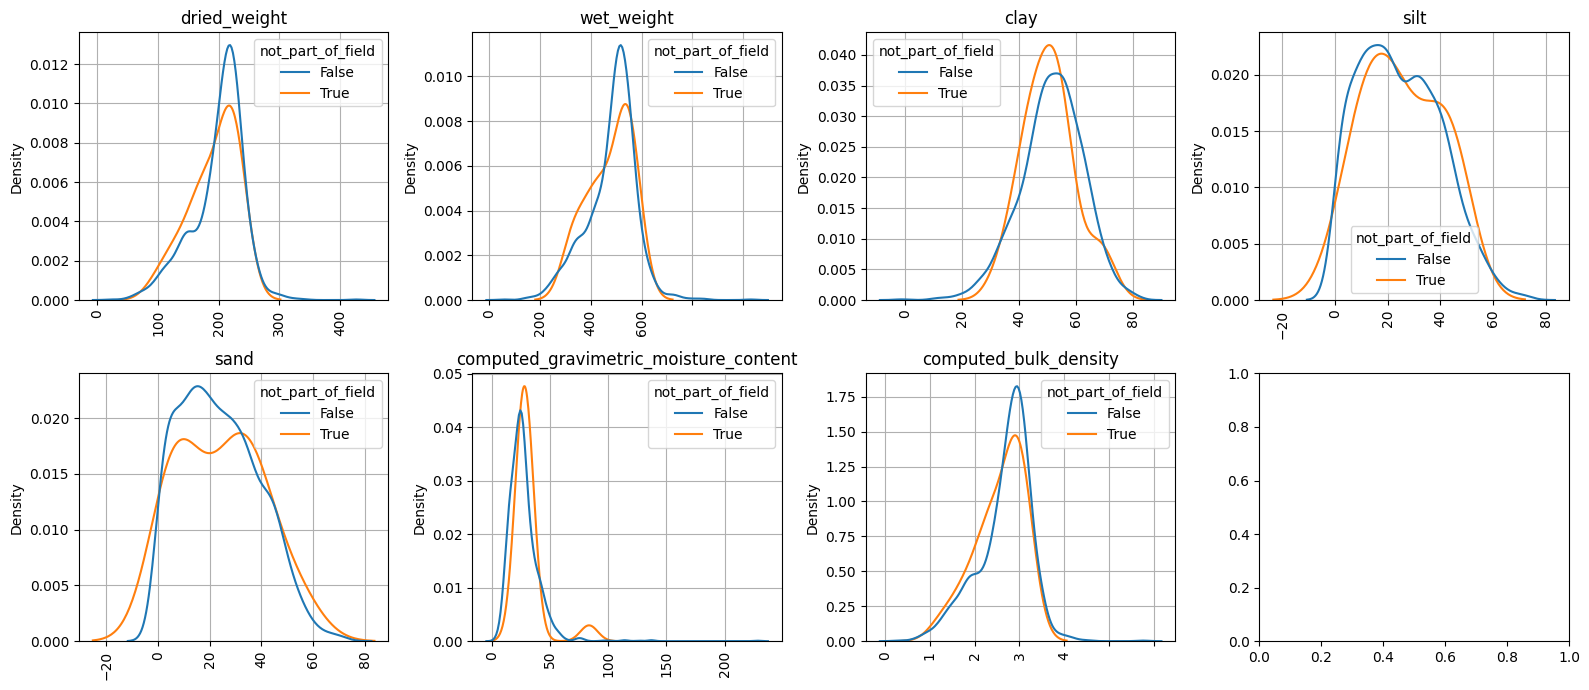

In [8]:
cols = [
    "dried_weight",
    "wet_weight",
    "clay",
    "silt",
    "sand",
    "computed_gravimetric_moisture_content",
    "computed_bulk_density",
]
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(cols):
        # sns.kdeplot(data=df,x=cols[i],ax=ax,hue='not_part_of_field',common_norm=False)
        # sns.kdeplot(data=df,x=cols[i],ax=ax,hue='not_part_of_project',common_norm=False)
        sns.kdeplot(
            data=df.loc[df.not_part_of_project == False],
            x=cols[i],
            ax=ax,
            hue="not_part_of_field",
            common_norm=False,
        )
        ax.set_title(cols[i])
        ax.set_xlabel("")
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=90)
        ax.grid()

fig.tight_layout()

#### dig into target (computed bulk density)

<Axes: xlabel='computed_bulk_density', ylabel='Count'>

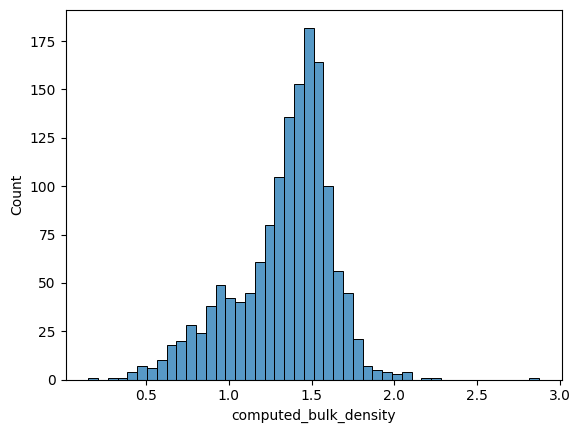

In [9]:
sns.histplot(df.computed_bulk_density)

^^ The bulk density of solid quartz is 2.65 g/cm3 ... so I'll treat anything above that as an outlier.
Furthermore, I'll assume that we're not workign with peats...so also throw out anything with a bulk density below 0.5

#### Further inspect gravimetric moisture, wet weight, dry weight, etc.
In the distributions plotted above, Gravimetric mositure content occasionally exceeds 100 (and, if it is a percentage...presumably it shouldn't?). However, according to a quick google search for the formula, it WOULD be possible for gravimetric mositure content to exceed 100 if the wet weight is more than twice the dry weight. See https://labmodules.soilweb.ca/gravimetric-soil-water-content/

Check this...


In [10]:
df[["wet_weight", "dried_weight"]].loc[df.computed_gravimetric_moisture_content > 100]

,wet_weight,dried_weight
541,135.2,62.8
542,151.0,76.4
543,159.7,80.7
544,188.2,100.0
546,143.1,67.2
1239,255.5,112.8
1245,305.4,96.7


In [11]:
df.loc[df.wet_weight <= df.dried_weight]

,field_id,project_id,sample_site_id,sub_sample_id,start_depth,end_depth,soil_hardness,dried_weight,wet_weight,clay,silt,sand,computed_gravimetric_moisture_content,computed_bulk_density,not_part_of_field,not_part_of_project


#### Is provided computed_gravimetric_moisture_content consistent with provided wet_weight and dry_weight for samples?

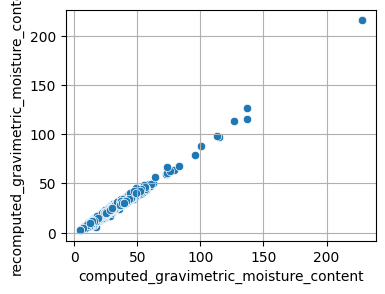

In [12]:
# check the calculation against the formula:
df["recomputed_gravimetric_moisture_content"] = [
    100 * (w - d) / d for w, d in zip(df.wet_weight, df.dried_weight)
]
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(
    data=df,
    x="computed_gravimetric_moisture_content",
    y="recomputed_gravimetric_moisture_content",
)
ax.grid()

##### ^^ Why does the provided gravimetric moisture content not fully align with what is computed from the provided wet and dry weights?
##### ^^ For the application of this model, will we have access to graivmetric moisture content as a predictor? 

#### Compute water weight
(Is the amount of moisture a soil can hold correlated with the dried weight?)

Correlation coefficient between dried weight and the weight of the contained moisture:
[[1.       0.177979]
 [0.177979 1.      ]]


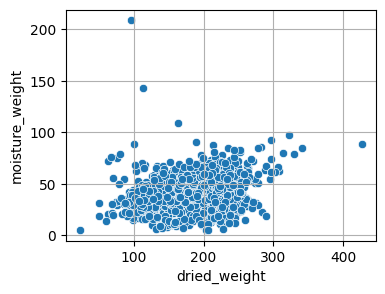

In [13]:
df["moisture_weight"] = df["wet_weight"] - df["dried_weight"]
print(
    "Correlation coefficient between dried weight and the weight of the contained moisture:"
)
print(np.corrcoef(df.dried_weight, df.moisture_weight))
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(data=df, x="dried_weight", y="moisture_weight", ax=ax)
ax.grid()

#### Do sand, silt, and clay percentages always sum to 100? If not, what's up?

In [14]:
df["sum_of_texture_variables"] = df["clay"] + df["sand"] + df["silt"]
df.loc[[abs(x - 100) > 0.01 for x in df.sum_of_texture_variables]]

,field_id,project_id,sample_site_id,sub_sample_id,start_depth,end_depth,soil_hardness,dried_weight,wet_weight,clay,silt,sand,computed_gravimetric_moisture_content,computed_bulk_density,not_part_of_field,not_part_of_project,recomputed_gravimetric_moisture_content,moisture_weight,sum_of_texture_variables
95,9054.0,362.0,53736,9673,30,35,2 - Above average hardness,212.5,237.2,42.393695,29.491223,-1.00000,14.079247,1.446562,False,False,11.623529,24.7,70.884918
107,9054.0,362.0,53737,9676,0,5,1 - Average hardness,126.4,139.4,-1.000000,17.553904,43.79906,11.828797,0.867238,False,False,10.284810,13.0,60.352964
110,9054.0,362.0,53737,9679,15,20,1 - Average hardness,171.5,196.6,37.285375,3.649358,70.00000,16.125831,1.177833,False,False,14.635569,25.1,110.934733
116,9054.0,362.0,53739,9694,0,5,2 - Above average hardness,183.7,198.7,49.157659,32.991552,10.00000,9.896135,1.257895,False,False,8.165487,15.0,92.149211





#### Relationship between dried_weight and bulk_density should be consistent?
'Computed' bulk density should be a scalar multiple of dry soil weight (which is a scalar multiple of dry soil mass).


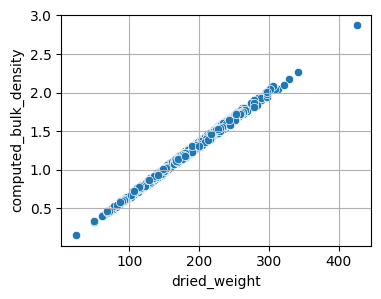

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(data=df, x="dried_weight", y="computed_bulk_density", ax=ax)
ax.grid()

#### We can back-calculate the slice volume
In theory, assuming the same soil coring aparatus was used for all data collection, then all of the slices should have the exact same volume (is this correct?). If so, that means that which means that true bulk density is directly proportional to the dry soil mass, which is a scalar multiple of dry soil weight. Infer the volume of each sample and visually test the above statement.

Mean volume is 149.42863444460167


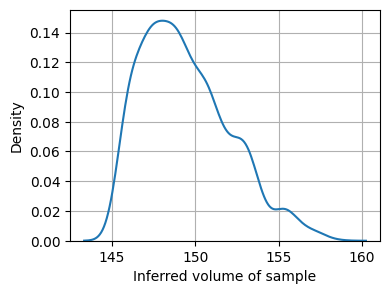

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
df["inferred_slice_volume"] = df.dried_weight / df.computed_bulk_density
sns.kdeplot(data=df, x="inferred_slice_volume", ax=ax)

ax.grid()
ax.set_xlabel("Inferred volume of sample")
print(f"Mean volume is {df.inferred_slice_volume.mean()}")

#### Inspect soil hardness data

In [17]:
df.soil_hardness.unique()

array(['1', '-999 - no_data', '1 - Average hardness',
       '0 - Below average hardness', '2 - Above average hardness',
       '3 - Maximal hardness'], dtype=object)

In [18]:
df.soil_hardness.value_counts()

soil_hardness
1 - Average hardness          577
0 - Below average hardness    380
2 - Above average hardness    283
-999 - no_data                151
3 - Maximal hardness           45
1                              27
Name: count, dtype: int64

In [19]:
# what's with the '1' without corresponding 'average hardness?' Throw out or lump with 'Average hardness?'
# If the 1 is all part of the same location, I will assume it is a data=entry error and re-map it to 1 - Average hardness
df.loc[df.soil_hardness == "1"].field_id.value_counts()
# it is...

field_id
9050.0    27
Name: count, dtype: int64

##### ^^ decide to lump '1' with 'Average hardness' since it's all part of the same field (assume data entry error)

In [20]:
df["soil_hardness"] = [
    "1 - Average hardness" if len(x) < 2 else x for x in df["soil_hardness"]
]
df["soil_hardness_numeric"] = [
    int(x.split(" ")[0]) if isinstance(x, str) else np.nan for x in df["soil_hardness"]
]
df["soil_hardness_numeric"] = [
    np.nan if x == -999 else x for x in df["soil_hardness_numeric"]
]

##### What does soil hardness correlate with?

In [21]:
df[df.select_dtypes(include=[np.number]).columns].corrwith(df["soil_hardness_numeric"])

field_id                                  -0.040412
project_id                                -0.233047
sample_site_id                            -0.683973
sub_sample_id                             -0.728900
start_depth                                0.008818
end_depth                                  0.008818
dried_weight                               0.080972
wet_weight                                -0.128700
clay                                       0.023002
silt                                      -0.016964
sand                                      -0.001575
computed_gravimetric_moisture_content     -0.471909
computed_bulk_density                      0.098300
recomputed_gravimetric_moisture_content   -0.477007
moisture_weight                           -0.548509
sum_of_texture_variables                  -0.025219
inferred_slice_volume                     -0.233419
soil_hardness_numeric                      1.000000
dtype: float64

##### ^^ Soil hardness appears to be a relatively good proxy for moisture content and slightly positively correlated with computed bulk density. 
Alas, there are ~150 nan values. Let's look into that...


In [22]:
df[
    ["field_id", "soil_hardness_numeric", "clay", "silt", "computed_bulk_density"]
].groupby("field_id").mean()

,soil_hardness_numeric,clay,silt,computed_bulk_density
field_id,,,,
0.0,0.666667,49.166030,27.523026,1.254965
6884.0,NaN,44.339465,24.376143,0.947329
6885.0,NaN,39.531533,30.295844,0.902443
6889.0,NaN,42.311267,31.043758,0.891962
6891.0,NaN,36.719061,30.209450,0.692279
6893.0,NaN,42.990365,35.515972,0.849158
6894.0,NaN,38.586202,30.767729,0.797930
6899.0,NaN,39.656538,36.703395,0.849382
6901.0,NaN,39.962265,29.330005,0.949143


##### ^^^ The bulk density values of the subset of fields for which there are no soil hardness observations appear to be drawn from a different population. 
They also appear too low for 'standard' bulk density (see, for example...but probably not the most reliable source, https://en.wikipedia.org/wiki/Bulk_density#:~:text=The%20bulk%20density%20of%20soil,and%201.6%20g%2Fcm3.). Furthermore, that group's clay values are substantilaly lower than the other data points. 


#### Inspect data at the 'slice' level
Label the slices using middle of slice depth; use value counts to assess whether all slices are (1) present and (2) 5 cm thick

In [23]:
df["slice_mid_depth"] = [
    (s + e) / 2 for s, e in zip(df["start_depth"], df["end_depth"])
]
df.slice_mid_depth.value_counts()

slice_mid_depth
7.5     165
12.5    165
17.5    165
22.5    165
32.5    165
27.5    164
2.5     162
37.5    162
42.5    150
Name: count, dtype: int64

#### How do various potential features change with depth?

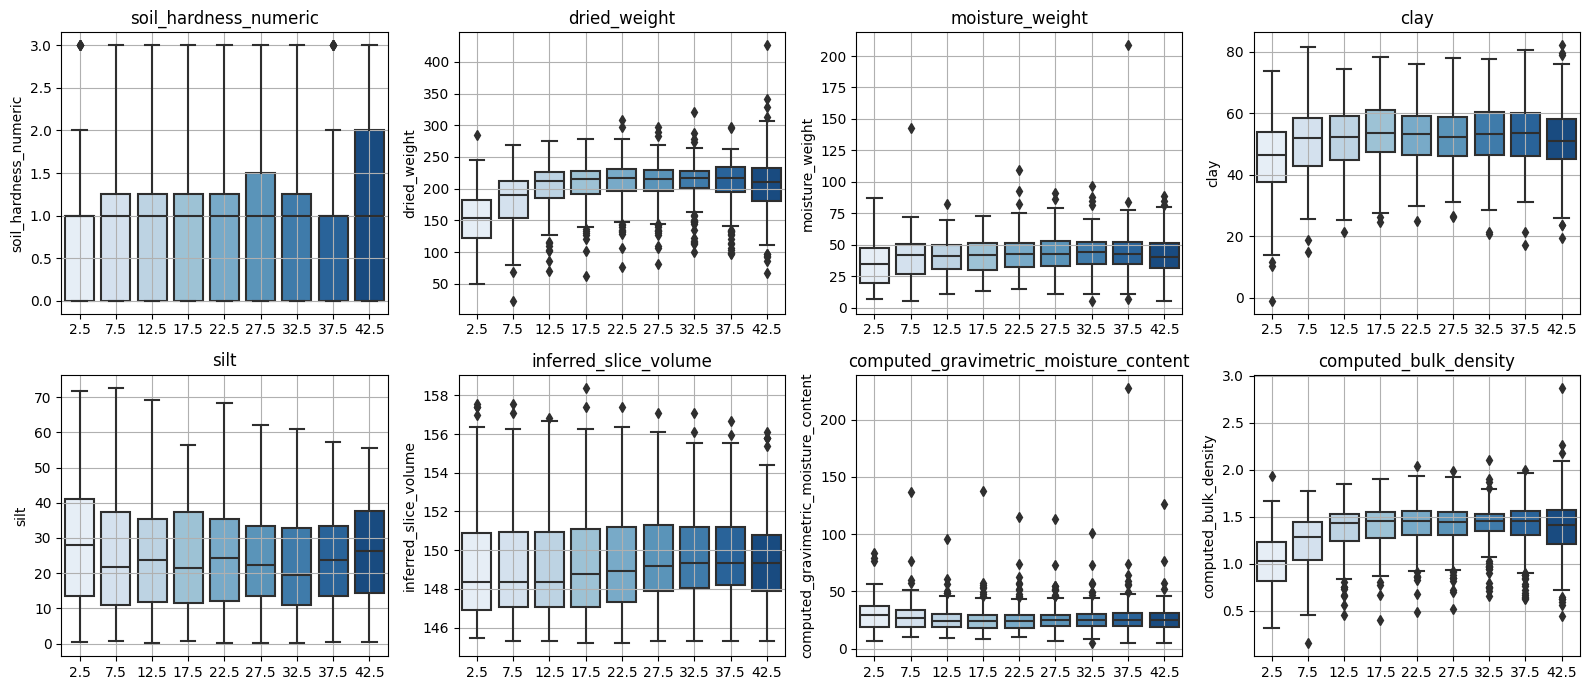

In [24]:
cols = [
    "soil_hardness_numeric",
    "dried_weight",
    "moisture_weight",
    "clay",
    "silt",
    "inferred_slice_volume",
    "computed_gravimetric_moisture_content",
    "computed_bulk_density",
]
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
for i, ax in enumerate(axes.reshape(-1)):
    sns.boxplot(data=df, x="slice_mid_depth", y=cols[i], ax=ax, palette="Blues")
    ax.set_title(cols[i])
    ax.set_xlabel("")
    ax.grid()

fig.tight_layout()

#### What is the relationship between computed_bulk_density and other variables?

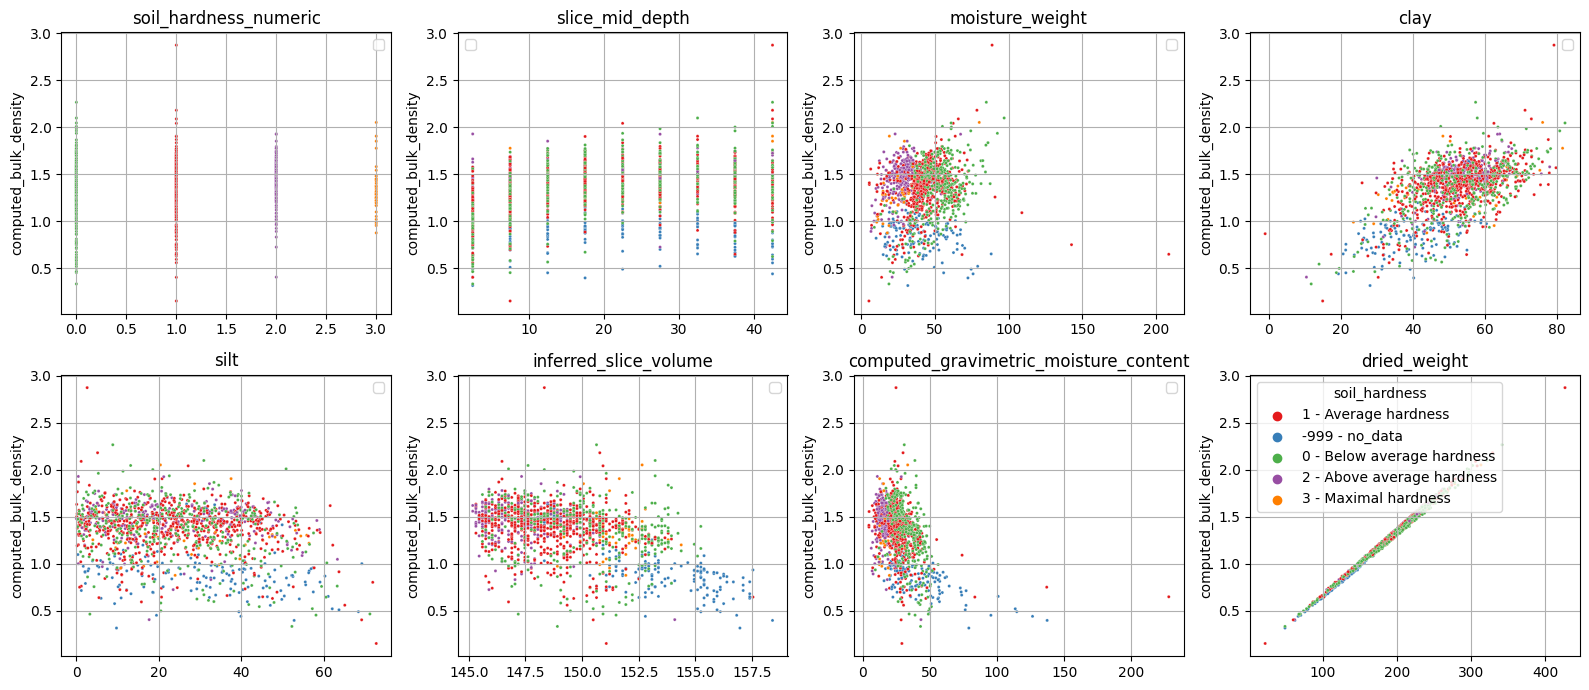

In [25]:
cols = [
    "soil_hardness_numeric",
    "slice_mid_depth",
    "moisture_weight",
    "clay",
    "silt",
    "inferred_slice_volume",
    "computed_gravimetric_moisture_content",
    "dried_weight",
]
fig, axes = plt.subplots(2, 4, figsize=(16, 7))

# dig a bit more into soil hardness. Make sure to highlight the population of data with missing soil hardness data

for i, ax in enumerate(axes.reshape(-1)):
    sns.scatterplot(
        data=df,
        y="computed_bulk_density",
        x=cols[i],
        ax=ax,
        palette="Set1",
        hue="soil_hardness",
        s=5,
    )
    ax.set_title(cols[i])
    ax.set_xlabel("")
    ax.grid()
    if i < 7:
        ax.legend("")
fig.tight_layout()

##### ^^ The samples with no 'soil hardness' observations appear to be (mild?) outliers on many fronts 
I will leave out the samples with no soil hardness data

<Axes: xlabel='soil_hardness_numeric', ylabel='computed_bulk_density'>

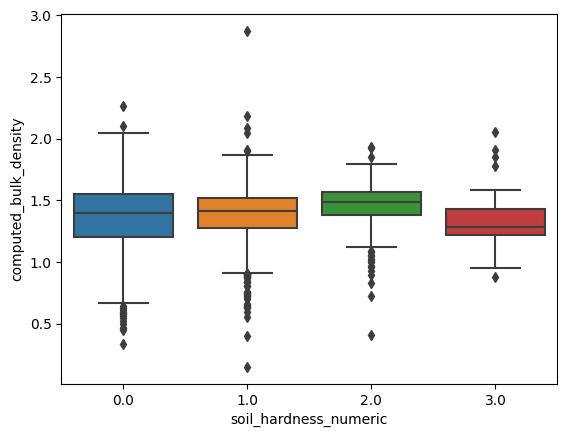

In [26]:
sns.boxplot(data=df, x="soil_hardness_numeric", y="computed_bulk_density")

In [27]:
df[df.select_dtypes(include=[np.number]).columns].corrwith(df["computed_bulk_density"])

field_id                                   0.293467
project_id                                 0.292283
sample_site_id                             0.440914
sub_sample_id                              0.195975
start_depth                                0.288290
end_depth                                  0.288290
dried_weight                               0.997599
wet_weight                                 0.932690
clay                                       0.591310
silt                                      -0.218983
sand                                      -0.203077
computed_gravimetric_moisture_content     -0.491185
computed_bulk_density                      1.000000
recomputed_gravimetric_moisture_content   -0.454218
moisture_weight                            0.141884
sum_of_texture_variables                   0.024802
inferred_slice_volume                     -0.478517
soil_hardness_numeric                      0.098300
slice_mid_depth                            0.288290
dtype: float

### Build Model: start with most basic model, expand

#### Define bespoke functions for use in model training/evaluation

In [28]:
def rmse(
    y_true: Union[pd.Series, list, np.array], y_pred: Union[pd.Series, list, np.array]
):
    """Returns the root mean squared error between two lists/series; assumes equal length"""
    return mean_squared_error(y_true, y_pred) ** 0.5


def group_train_test_split(
    X_df: pd.DataFrame,
    y_df: pd.DataFrame,
    group: List[str],
    test_size: float = 0.3,
    random_state: int = 42,
):
    """Splits data into training and test sets; ensures all members of specified group are in test OR train, not both"""
    # Xy_df=X_df.merge(y_df,right_index=True,left_index=True)
    Xy_df = X_df.merge(y_df, right_index=True, left_index=True)
    splitter = GroupShuffleSplit(test_size=0.2, random_state=42, n_splits=2)
    split = splitter.split(Xy_df, groups=Xy_df[group])
    train_idxs, test_idxs = next(split)
    # mimic train_test_split return order
    return (
        X_df.iloc[train_idxs],
        X_df.iloc[test_idxs],
        y_df.iloc[train_idxs],
        y_df.iloc[test_idxs],
    )


def build_run_score(
    x_cols: List[str],
    target_col: str,
    Xy_df: pd.DataFrame,
    regressor,
    scaler=None,
    test_size: float = 0.3,
    random_state: int = 42,
):
    """Sets up training and testing sets, fits regression, makes prediction, returns score
    Args:
        x_cols: list of string names of columns in Xy_df to use as prediction features
        target_col: string name of column in Xy_df that is the regression target
        Xy_df: pandas dataframe containing testing/training dat
        regressor: model object (e.g., sklearn LinearRegression() or xgboost XGBRegressor()
        scaler: sklearn scaler object (e.g., MinMaxScaler()), used only if not None
        test_size: fraction of Xy_df data to be held out for testing
        random_state: random_state initialization"""
    if scaler is not None:
        X_df = scaler.fit_transform(Xy_df[x_cols])
    else:
        X_df = Xy_df[x_cols]

    y_df = Xy_df[target_col]

    # split training and test set, ensuring that no hours from the same date are chosen to prevent memorization
    X_train, X_test, y_train, y_test = group_train_test_split(
        X_df, y_df, group=["field_id"], test_size=test_size, random_state=random_state
    )
    X_train["is_test"] = 0
    X_test["is_test"] = 1

    X = pd.concat([X_train, X_test])
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    return_df = Xy_df.merge(X["is_test"], right_index=True, left_index=True).merge(
        pd.DataFrame(regressor.predict(X_test), columns=["prediction"]),
        right_index=True,
        left_index=True,
    )

    return (
        y_test,
        y_pred,
        return_df,
        rmse(y_test, y_pred),
        r2_score(y_test, y_pred),
        regressor,
    )

#### Throw out suspect points/keep only the data associated with a project for buildling models

In [29]:
# throw out obviously bad data (where soil textures don't sum to 100)
df = df.loc[
    [abs(x - 100) < 0.01 for x in df.sum_of_texture_variables]
]  # only variables where clay+silt+sand = 100
df["root_slice_mid_depth"] = [x**0.5 for x in df.slice_mid_depth]
# Per logic above, use only the subset of data that are 'affiliated' with a project and
# throw out the data without soil-hardness measurements (because they appear to be outliers on multiple fronts)
subset_df = df.loc[
    (df.not_part_of_project == False)
    & (
        df.soil_hardness_numeric.isin([0, 1, 2, 3])
        & (df.computed_bulk_density < 2.65)
        & (df.computed_bulk_density > 0.5)
    )
]

#### Notes on feature selection/choice

In order to compute gravimetric moisture content, a lab must have computed both wet_weight and dried_weight. Dried_weight is directly proportional to bulk density. For that reason, I'll assume that we shouldn't use gravimetric moisture content as a feature, on the assumption that, if we've got that, we've also got access to dried_weight, which is far and away the best predictor of bulk density here. 


In [30]:
# Dictionaries to hold results
y_test = {}
y_pred = {}
return_df = {}
rmse_score = {}
r2 = {}

#### For all, use computed_bulk_density as the regression target

In [31]:
target_col = "computed_bulk_density"

#### Set up/train models

In [32]:
# basic Linear Regression model with minimal features
x_cols = [
    "clay",
    "silt",
    "field_id",
]  # only need two of the three features b/w clay, sand, and silt (b/c they sum to 100). Field id included for group_shuffle_split

(
    y_test["basic_lr"],
    y_pred["basic_lr"],
    return_df["basic_lr"],
    rmse_score["basic_lr"],
    r2["basic_lr"],
    _,
) = build_run_score(
    x_cols,
    target_col,
    subset_df,
    LinearRegression(),
    StandardScaler().set_output(
        transform="pandas"
    ),  # normalize data to mean 0 and variance 1
)

print(f"RMSE is {rmse_score}; r2 is {r2}.")

RMSE is {'basic_lr': 0.23035839764700658}; r2 is {'basic_lr': 0.1052521634905551}.


In [33]:
# Add more features, including an engineered variable, root_slice_mid_depth, which is the square root of the mid-slice depth (cm)
# of each sample

x_cols = [
    "clay",
    "silt",
    "root_slice_mid_depth",
    "soil_hardness_numeric",
    "field_id",
]  # only need two of the three features b/w clay, sand, and silt (b/c they sum to 100). Field id included for group_shuffle_split

(
    y_test["expanded_lr"],
    y_pred["expanded_lr"],
    return_df["expanded_lr"],
    rmse_score["expanded_lr"],
    r2["expanded_lr"],
    _,
) = build_run_score(
    x_cols,
    target_col,
    subset_df,
    LinearRegression(),
    StandardScaler().set_output(
        transform="pandas"
    ),  # normalize data to mean 0 and variance 1
)

print(f"RMSE is {rmse_score}; r2 is {r2}.")

RMSE is {'basic_lr': 0.23035839764700658, 'expanded_lr': 0.22200269002117326}; r2 is {'basic_lr': 0.1052521634905551, 'expanded_lr': 0.16898467511509763}.


In [34]:
# Change model approach to something that can capture non-linearies without feature engineering
# basic XGBoost model with minimal features
x_cols = [
    "clay",
    "silt",
    "field_id",
]  # only need two of the three features b/w clay, sand, and silt (b/c they sum to 100). Field id included for group_shuffle_split

(
    y_test["basic_xgb"],
    y_pred["basic_xgb"],
    return_df["basic_xgb"],
    rmse_score["basic_xgb"],
    r2["basic_xgb"],
    _,
) = build_run_score(
    x_cols,
    target_col,
    subset_df,
    XGBRegressor(),
)

In [35]:
# Change model approach to something that can capture non-linearies without feature engineering
# basic XGBoost model with minimal features
x_cols = [
    "clay",
    "silt",
    "slice_mid_depth",
    "soil_hardness_numeric",
    "field_id",
]  # only need two of the three features b/w clay, sand, and silt (b/c they sum to 100). Field id included for group_shuffle_split

(
    y_test["expanded_xgb"],
    y_pred["expanded_xgb"],
    return_df["expanded_xgb"],
    rmse_score["expanded_xgb"],
    r2["expanded_xgb"],
    _,
) = build_run_score(
    x_cols,
    target_col,
    subset_df,
    XGBRegressor(),
)

#### Figure plotting res|ults of all four models

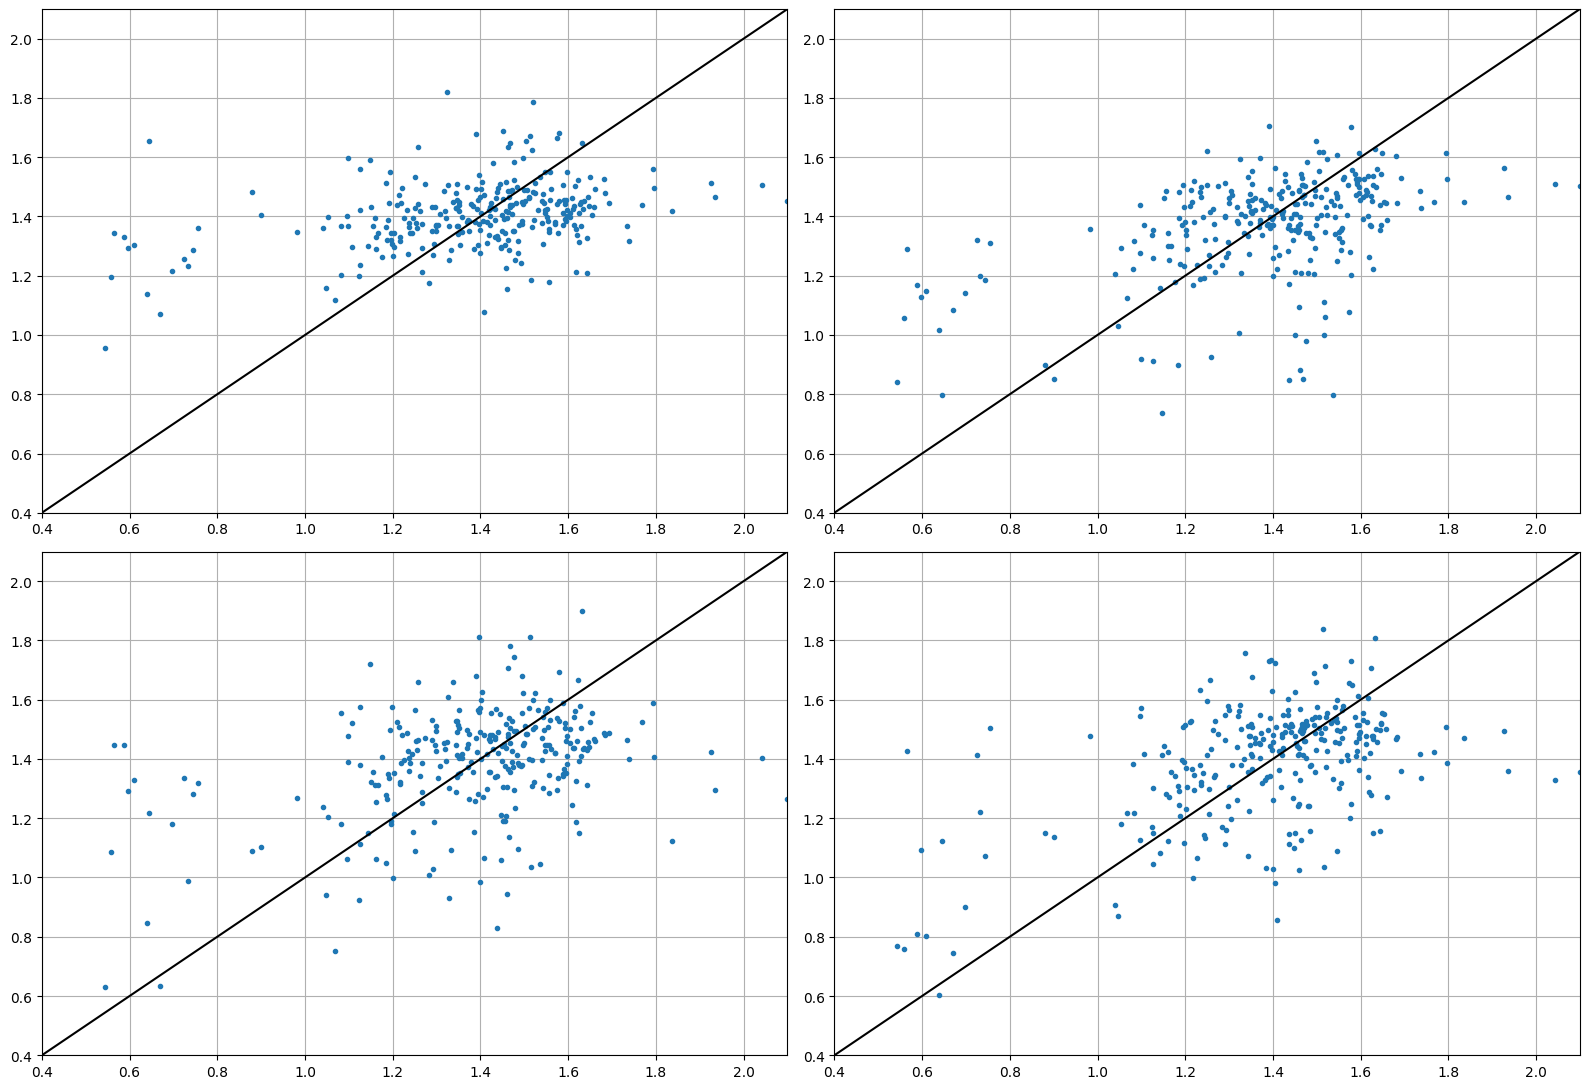

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
models = ["basic_lr", "expanded_lr", "basic_xgb", "expanded_xgb"]
for i, model in enumerate(models):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[models[i]], y_pred[models[i]], ".")
    plt.xlim([0.4, 2.1])
    plt.ylim([0.4, 2.1])
    plt.grid()
    plt.plot([0.4, 2.1], [0.4, 2.1], "k")
fig.tight_layout()

#### Models' performance summary

In [42]:
for model in models:
    print(f"For the {model} model:")
    print(f"RMSE is {rmse_score[model]}; r2 is {r2[model]}.")
    print("")

For the basic_lr model:
RMSE is 0.23035839764700658; r2 is 0.1052521634905551.

For the expanded_lr model:
RMSE is 0.22200269002117326; r2 is 0.16898467511509763.

For the basic_xgb model:
RMSE is 0.24272921625139898; r2 is 0.0065713830401319395.

For the expanded_xgb model:
RMSE is 0.2243400473470033; r2 is 0.1513938527812284.



### Answers to questions

#### Inspect and clean data

##### What type of information does our dataset contain? How is the data organized?
Soil texture data, wet and dry weights for soil-core slices, variables computed from the wet and dry weights and volume. Each row in the dataset corresponds to measurements for a given 5-cm slice (with a subset_of a single core from within a 

##### What errors do you see in the data? 
- There are a few clear errors (for example, negative percentages for sand percentage; clay+sand+silt that sum to more or less than 100). - There are some computed bulk density values that exceed the bulk density of solid quartz (2.65 g/cm3): this is likely an error. 
Missing data for the soil hardness may be an error (or it could be that that type of soil is not able to be characterized on a 'soil hardeness' scale). 
- I'll note that there are quite a few samples that *could* contain errors depending on factors involved in collecting the data. For example, all of the data that have no soil hardness measurements happen to have particularly low bulk density and lower clay content than the rest of the population; this could mean those are errors; this could also mean we're dealing with peaty loams. 

##### What can you do about these errors?
Ways to deal with errors include (1) dropping the data point; (2) interpolating (if additional information is available); (3) buildling a model to interpolate (something that could be done for a soil-hardness characterization, depending on context and available data)

##### Do you see any outliers?
There are only a few clear outliers (for example, bulk density values that are extremely low (under 0.5 g/cm3, for example) seem atypical (unless we're in a peat bog). Whether something is an 'outlier' also depends on context.

#### Visualize Data
Create a few plots to visualize the data. Use any plotting library, but matplotlib is fine. These don't need to be fancy.

##### What plots did you create and why?
- I plotted univariate distributions to get a sense for distribution shape and outliers. 
- I also looked at ways in which the variables in the dataset vary with each other (e.g., how do potential features change with slice depth); I did this for several reasons, including to know whether there is a linear relationship between potential features and the targets. 
- I looked at bivariate distributions (e.g., how does the distribution of clay content change with soil-hardness measurement) to get a sense for any variable interactions.

##### What patterns do you see?
Among others:
- Increasing bulk density with depth
- Increasing clay content with depth
- Soil hardness is a weak proxy for moisture content

#### Build Model

##### What model are you using and why? 
I used both a basic linear regression and an XGBoost. Linear regressions are easy to explain to stakeholders (and to yourself). They are often hard to beat, performance wise. At bare minimum, linear regressions work well as a baseline model for comparison. XGBoost is a decision-tree based model that often does well piecing out nonlinear relationships between variables; it doesn't depend on feature engineering.

##### Can you explain how this model works?
Least squares linear regression describes a linear relationship between features and a target. XGBoost is a 'gradient boosting' method that uses an evolving ensemble of decision trees to predict a target.

##### How do you pick which features to use? Why did you pick those?

##### Given the structure of the data, how do you approach training and testing, and why?
To prevent memorization, I ensured that the 


##### How do you pick the best model?
The model that Ideally, I would have used bootstrapping to score/evaluate/pick the model, but time is short!

#### Interpret Results

##### Plot actual vs predicted
See above for the test set (30% of the entire dataset).

##### Choose and evaluate metrics. What do they mean? Does this mean the model is good or bad? 
I'll use standard evaluation metrics r2 and RMSE. RMSE is the standard deviation of the difference between the model predictions and the corresponding 'true' values. It gives us a sense for how far our model is from 'truth' in the same units as the regression target.
R2 explains the fraction of the variance in the target that can be explained using the model. Both metrics don't let us know if the model is 'good' or 'bad': they let us compare the quality of the predictions of different models. 'Good'/'bad' depends on the business use case.

##### Where may the model be biased? 
- The data are more complete for upper-layer slices than for the lowest layer slices: this introduces bias.
- The fact that I didn't do any resampling when training means I may have introduced bias.
- If the data used to train the model are not representative of the population in which we're applying the model, we could consider predictions biased (colloquially) toward the training set.
- Also potentially biased at the edges of the target distribution.

#### Draw conclusions -  what can we do to further validate this model and what would be next steps?
1. The models are all pretty crappy. The 'best' model was the expanded Linear regression model, with a RMSE of 0.22 g/cm3 and an r2 of 0.17
2. Phone a friend! I'd call up the team who gathered the data and better understand how the data were colelcted/computed, get input from that team on what parts of the dataset that they have (and don't have) faith in, get their input on other variables that may influence bulk density, that may not be captured in the dataset, etc.
3. Ideally we'd have some more features with which to predict bulk density. Soil texture and 'hardness' are not terribly information rich, it seems
4. More training data from a wide variety of locations
5. Understanding how the lab 'computed' bulk density
6. Increased understanding of what features would be available for model application and how (if) training data align well with that data
  
